In [2]:
%reload_ext autoreload
%autoreload 2
    
import torch
import gc
from consistory_run import load_pipeline, run_anchor_generation, run_extra_generation
from consistory_utils import StoryPipelineStore
import random
from matplotlib import pyplot as plt

/workspace/oa_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/workspace/oa_venv/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/workspace/oa_venv/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/workspace/oa_venv/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register

In [2]:
gpu = 0
story_pipeline = load_pipeline(gpu)

story_pipeline_store = StoryPipelineStore()

style = ""
subject = "A rugger adventurer with tousled hair, comic book stile"
concept_token = ['adventurer']
anchor_settings = ["standing", "standing"]

seed = random.randint(0, 10000)
mask_dropout = 0.5
same_latent = False

anchor_prompts = [f'{style}{subject} {setting}' for setting in anchor_settings]

# Reset the GPU memory tracking
torch.cuda.reset_max_memory_allocated(gpu)

anchor_out_images, anchor_image_all, anchor_cache_first_stage = \
        run_anchor_generation(story_pipeline, anchor_prompts, concept_token, 
                       seed=seed, mask_dropout=mask_dropout, same_latent=same_latent,
                       cache_cpu_offloading=True, story_pipeline_store=story_pipeline_store)

/workspace/oa_venv/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Fetching 16 files:  12%|█▎        | 2/16 [00:00<00:00, 17.67it/s]






















































































































Fetching 16 files:  25%|██▌       | 4/16 [00:03<00:13,  1.16s/it]


















































































































Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 14.99it/s]
/workspace/oa_venv/lib/python3.10/site-packages/torch/cuda/memory.py:330: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


[(1, 50)]


  0%|          | 0/50 [00:00<?, ?it/s]/workspace/oa_venv/lib/python3.10/site-packages/diffusers/utils/torch_utils.py:106: UserWarning: ComplexHalf support is experimental and many operators don't support it yet. (Triggered internally at ../aten/src/ATen/EmptyTensor.cpp:41.)
  x_freq = fftn(x, dim=(-2, -1))
/workspace/oa_venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 50/50 [00:23<00:00,  2.10it/s]


Anchor images:


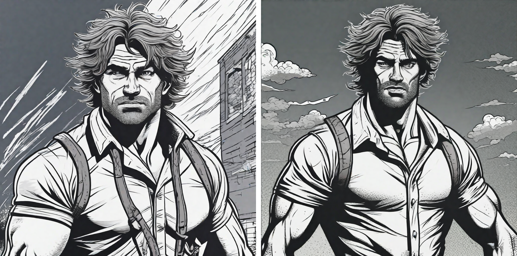

In [3]:
print('Anchor images:')
display(anchor_image_all)

1st stage images:


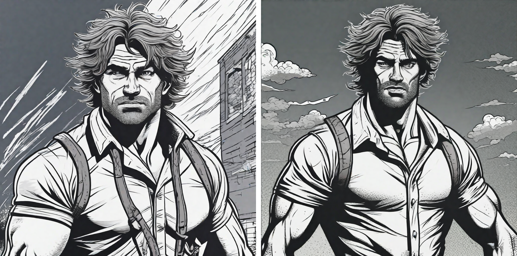

In [4]:
import numpy as np
downscale_rate = 4
from utils.ptp_utils import view_images
print('1st stage images:')
view_images([np.array(x) for x in story_pipeline_store.first_stage.images[0]], display_image=False, downscale_rate=downscale_rate)

In [5]:
from utils.general_utils import gaussian_smooth, cyclic_nn_map
LATENT_RESOLUTIONS = [32, 64]

device='cuda'
batch_size = len(anchor_prompts)
last_masks = story_pipeline.attention_store.last_mask

dift_features = story_pipeline.unet.latent_store.dift_features['261_0'][batch_size:]
dift_features = torch.stack([gaussian_smooth(x, kernel_size=3, sigma=1) for x in dift_features], dim=0)

nn_map, nn_distances = cyclic_nn_map(dift_features, last_masks, LATENT_RESOLUTIONS, device)

torch.cuda.empty_cache()


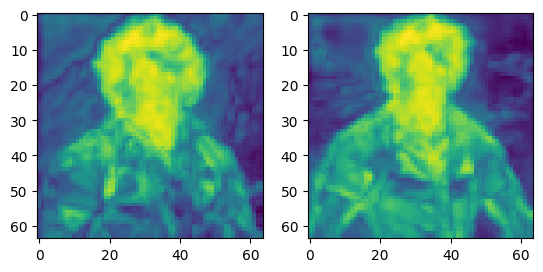

In [6]:
nn_map_reshape = story_pipeline_store.first_stage.nn_map[0][64].reshape(2,2,64,64)
nn_distances_reshape = story_pipeline_store.first_stage.nn_distances[0][64].reshape(2,2,64,64)
f, axxs = plt.subplots(1, 2)
mask = 1-nn_distances_reshape
axxs[0].imshow(mask[0][1].cpu())
axxs[1].imshow(mask[1][0].cpu())

In [7]:
mask[0][1].min(), mask[0][1].max(), mask[0][1].mean()

(tensor(0.2080, device='cuda:0', dtype=torch.float16),
 tensor(0.9468, device='cuda:0', dtype=torch.float16),
 tensor(0.5513, device='cuda:0', dtype=torch.float16))

In [8]:
# 1st image
target_data_list = {
    'xt':[_xt_save[0:1].cpu() for _xt_save in story_pipeline_store.first_stage.xt_save[0]],
    'h_mid':[_mid_save[0::2].cpu()  for _mid_save in story_pipeline_store.first_stage.mid_save_list[0]],
    'prompt_embed':story_pipeline_store.first_stage.prompt_embeds[0][0::2].cpu(),
    'mask_64': 1 - story_pipeline_store.first_stage.nn_distances[0][64].reshape(2,2,64,64)[0][1].cpu() 
}
image = story_pipeline_store.first_stage.images[0][0]

# # 2nd image
# target_data_list = {
#     'xt':[_xt_save[1:2].cpu() for _xt_save in story_pipeline_store.first_stage.xt_save[0]],
#     'h_mid':[_mid_save[1::2].cpu()  for _mid_save in story_pipeline_store.first_stage.mid_save_list[0]],
#     'prompt_embed':story_pipeline_store.first_stage.prompt_embeds[0][1::2].cpu(),
#     'mask_64': 1 - story_pipeline_store.first_stage.nn_distances[0][64].reshape(2,2,64,64)[1][0].cpu() 
# }
# image = story_pipeline_store.first_stage.images[0][1]

[(1, 50)]


  0%|          | 0/50 [00:00<?, ?it/s]/workspace/oa_venv/lib/python3.10/site-packages/diffusers/models/lora.py:228: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(
100%|██████████| 50/50 [00:11<00:00,  4.25it/s]


Extra prompt: A rugger adventurer with tousled hair, comic book stile sitting


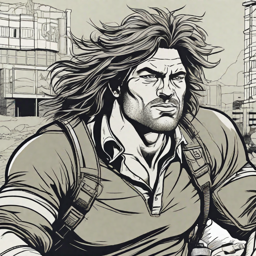

[(1, 50)]


100%|██████████| 50/50 [00:11<00:00,  4.25it/s]


Extra prompt: A rugger adventurer with tousled hair, comic book stile running


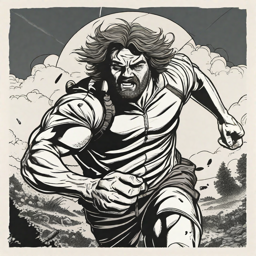

[(1, 50)]


100%|██████████| 50/50 [00:11<00:00,  4.23it/s]


Extra prompt: A rugger adventurer with tousled hair, comic book stile walking


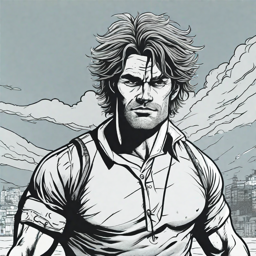

[(1, 50)]


100%|██████████| 50/50 [00:11<00:00,  4.22it/s]


Extra prompt: A rugger adventurer with tousled hair, comic book stile standing


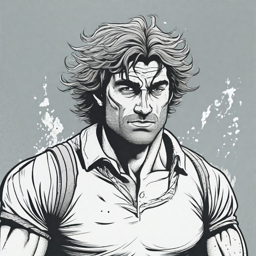

[(1, 50)]


100%|██████████| 50/50 [00:11<00:00,  4.20it/s]


Extra prompt: A rugger adventurer with tousled hair, comic book stile sitting


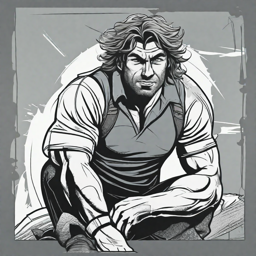

Maximum GPU memory used: 19.86 GB


In [9]:
BASE_NUM = 5
import os

extra_settings = ["sitting", "running", "walking", "standing", "sitting"]
extra_prompts = [f'{style}{subject} {setting}' for setting in extra_settings]

if BASE_NUM > 0:
    os.makedirs('./base', exist_ok=True)
    mid_last_base = []
    extra_prompts_list = []
    for i in range(BASE_NUM):
        seed = random.randint(0, 10000)
        r_num = random.randint(0, len(extra_settings) - 1)
        extra_prompt = extra_prompts[r_num]

        extra_out_images, extra_image_all = run_extra_generation(story_pipeline, [extra_prompt], concept_token, anchor_cache_first_stage, 
                                                    seed=seed, mask_dropout=mask_dropout, same_latent=same_latent, cache_cpu_offloading=True,
                                                                story_pipeline_store=story_pipeline_store)
    
        print(f'Extra prompt: {extra_prompt}')
        display(extra_image_all)

In [11]:
import os 
os.makedirs('./experiments', exist_ok=True)
os.makedirs('./experiments/consistory_adventurer', exist_ok=True)
os.makedirs('./experiments/consistory_adventurer/2504292003', exist_ok=True)

In [12]:
import pickle
with open(f'/workspace/Diploma/OneActor/experiments/consistory_adventurer/2504292003/target_data.pkl', 'wb') as f:
    pickle.dump(target_data_list, f)
image.save('/workspace/Diploma/OneActor/experiments/consistory_adventurer/2504292003/target.jpg')

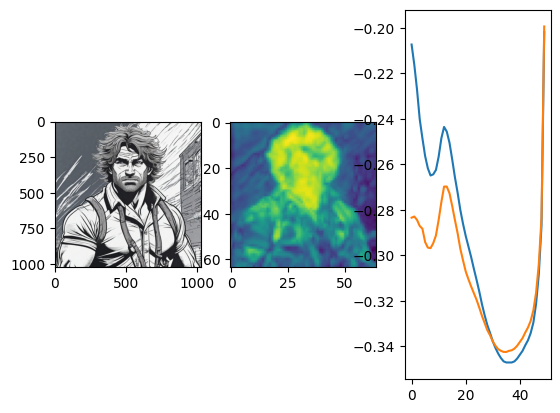

In [13]:
f, axxs = plt.subplots(1, 3)
axxs[0].imshow(np.asarray(image))
axxs[1].imshow(target_data_list['mask_64'])
axxs[2].plot([h[0].mean() for h in target_data_list['h_mid']])
axxs[2].plot([h[1].mean() for h in target_data_list['h_mid']])

[(1, 50)]


100%|██████████| 50/50 [00:15<00:00,  3.14it/s]


Extra prompt: A rugger adventurer with tousled hair, comic book stile sitting


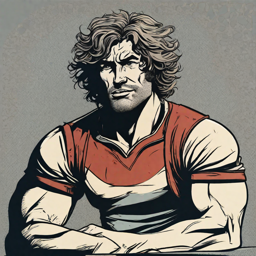

[(1, 50)]


100%|██████████| 50/50 [00:15<00:00,  3.16it/s]


Extra prompt: A rugger adventurer with tousled hair, comic book stile running


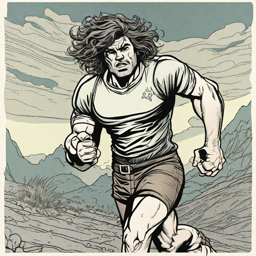

[(1, 50)]


100%|██████████| 50/50 [00:15<00:00,  3.15it/s]


Extra prompt: A rugger adventurer with tousled hair, comic book stile sitting


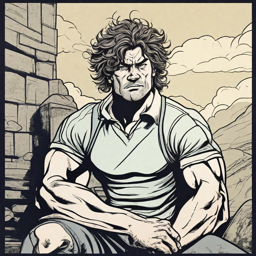

[(1, 50)]


100%|██████████| 50/50 [00:15<00:00,  3.16it/s]


Extra prompt: A rugger adventurer with tousled hair, comic book stile walking


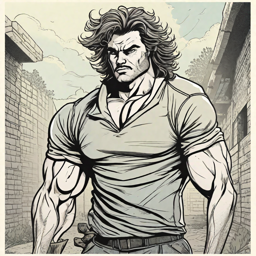

[(1, 50)]


100%|██████████| 50/50 [00:15<00:00,  3.15it/s]


Extra prompt: A rugger adventurer with tousled hair, comic book stile running


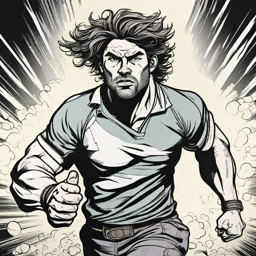

In [23]:
BASE_NUM = 5
import os

extra_settings = ["sitting", "running", "walking", "standing", "sitting"]
extra_prompts = [f'{style}{subject} {setting}' for setting in extra_settings]

if BASE_NUM > 0:
    os.makedirs('./base', exist_ok=True)
    mid_last_base = []
    extra_prompts_list = []
    for i in range(BASE_NUM):
        seed = random.randint(0, 10000)
        r_num = random.randint(0, len(extra_settings) - 1)
        extra_prompt = extra_prompts[r_num]

        extra_out_images, extra_image_all = run_extra_generation(story_pipeline, [extra_prompt], concept_token, anchor_cache_first_stage, 
                                                    seed=seed, mask_dropout=mask_dropout, same_latent=same_latent, cache_cpu_offloading=True,
                                                                story_pipeline_store=story_pipeline_store)
    
        print(f'Extra prompt: {extra_prompt}')
        display(extra_image_all)

In [14]:
base_data_list = []
base_images = []
for i in range(1, len(story_pipeline_store.first_stage.prompt_embeds)):
    base_data_list.append({
        'xt':[x.cpu() for x in story_pipeline_store.first_stage.xt_save[i]],
        'h_mid':[x.cpu() for x in story_pipeline_store.first_stage.mid_save_list[i]],
        'prompt_embed':story_pipeline_store.first_stage.prompt_embeds[i].cpu(),
        'mask_64': 1 - story_pipeline_store.first_stage.nn_distances[i][64].reshape(1,2,64,64)[0][1].cpu() 
    })

for i in range(1, len(story_pipeline_store.first_stage.prompt_embeds)):
    base_images.append(story_pipeline_store.first_stage.images[i][0])

In [15]:
os.makedirs('/workspace/Diploma/OneActor/experiments/consistory_adventurer/2504292003/base', exist_ok=True)
with open(f'/workspace/Diploma/OneActor/experiments/consistory_adventurer/2504292003/base/base_data_list.pkl', 'wb') as f:
    pickle.dump(base_data_list, f)

for i in range(len(base_images)):
    base_images[i].save(f'/workspace/Diploma/OneActor/experiments/consistory_adventurer/2504292003/base/base_{i}.jpg')

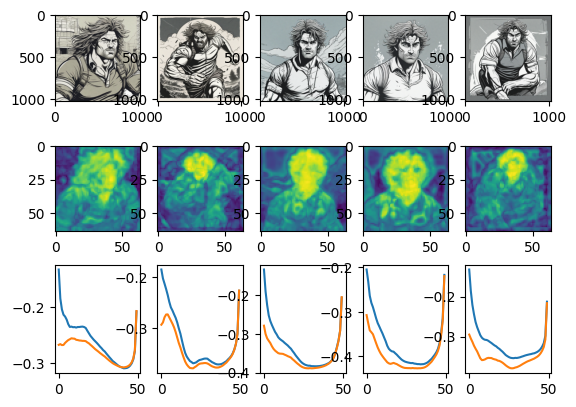

In [16]:
f, axxs = plt.subplots(3, len(base_data_list))
for i in range(len(base_data_list)):
    axxs[0][i].imshow(np.asarray(base_images[i]))
    axxs[1][i].imshow(base_data_list[i]['mask_64'])
    axxs[2][i].plot([h[0].mean() for h in base_data_list[i]['h_mid']])
    axxs[2][i].plot([h[1].mean() for h in base_data_list[i]['h_mid']])

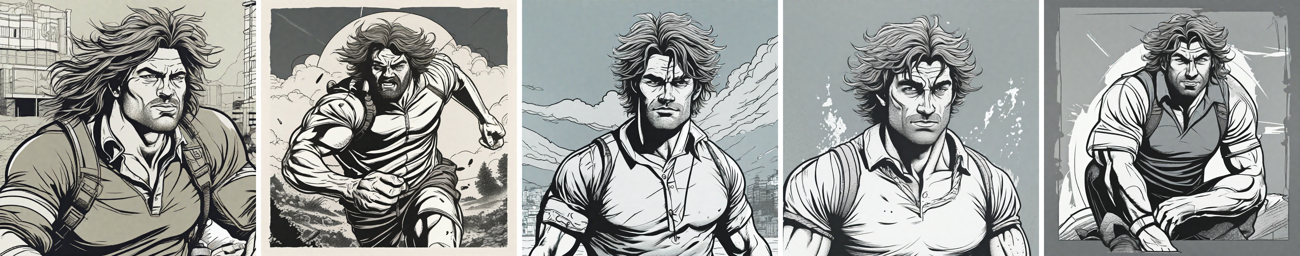

In [17]:
from utils.ptp_utils import view_images
view_images([np.array(x[0]) for x in story_pipeline_store.first_stage.images[1:]], display_image=False, downscale_rate=4)

In [18]:
torch.cuda.reset_max_memory_allocated(gpu)

In [19]:
print(torch.cuda.memory_allocated()/1024**2)
print(torch.cuda.memory_cached()/1024**2)

13001.93896484375
13528.0


/workspace/oa_venv/lib/python3.10/site-packages/torch/cuda/memory.py:440: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [20]:
torch.cuda.empty_cache()

In [3]:
print(torch.cuda.memory_allocated()/1024**2)
print(torch.cuda.memory_cached()/1024**2)

0.0
0.0


/workspace/oa_venv/lib/python3.10/site-packages/torch/cuda/memory.py:440: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(
